# Практическое задание

Задачи (в соответствии с программой практики):
1. Реализовать стохастическую генеративную модель как приложение на языке Python c помощь библиотеки pymc. Не использовать предыдущую версию библиотеки - pymc3!
2.	Разъяснить в комментариях, зачем используется та или иная строчка кода
3.	Обучить модель на данных о числе новых выявленных случаев заболевания covid-19 в период с 01.01.2020 по 01.12.2020 в странах: Россия, Италия, Германия и Франция. Для каждой страны не учитывать дни до того как заболеваемость превысит 100 случаев в день!
4.	Оценить динамику эффективного репродуктивного числа R(t)
5.  Предсказать число зарегистрированных случаев в день и R(t) для диапазона дат 02.12.2020 по 14.12.2020. Сравнить с реальными данными.


In [1]:
pip install  pymc==5.23.0 preliz==0.19.0 arviz==0.21.0 numpy==1.26.4 pandas scipy matplotlib==3.10.3 plotly==6.1.2 polars==1.30.0 covid19dh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 96.8 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 1.25.2
    Uninstalling polars-1.25.2:
      Successfully 

In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os
import shutil

from covid19dh import covid19
import pymc as pm
import arviz as az
from scipy import stats
import pytensor
import pytensor.tensor as tt
from pytensor.tensor.conv import conv2d

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Устанавливаем seed для воспроизводимости MCMC
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [4]:
# Загрузка данных для нужных стран за указанный период
countries = ["Russia", "Italy", "Germany", "France"]
# Загрузка данных с помощью библиотеки covid19dh
df, src = covid19(
    country=countries,
    start="2020-01-01",
    end="2020-12-14",
    verbose=False
)
# Переименуем столбец с названием региона в country для удобства
df = df.rename(columns={"administrative_area_level_1": "country"})

# Сортировка данных по стране и дате и сброс индекса
df = df.sort_values(["country", "date"]).reset_index(drop=True)
# Сохранение загруженных данных в CSV файл
df.to_csv("covid_data_2020.csv", index=False)

# Вывод последних 5 строк датафрейма для проверки
df.tail(5)

,id,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,icu,vent,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,facial_coverings,vaccination_policy,elderly_people_protection,government_response_index,stringency_index,containment_health_index,economic_support_index,administrative_area_level,country,administrative_area_level_2,administrative_area_level_3,latitude,longitude,population,iso_alpha_3,iso_alpha_2,iso_numeric,iso_currency,key_local,key_google_mobility,key_apple_mobility,key_jhu_csse,key_nuts,key_gadm
1290,f90dfca0,2020-12-10,2546113.0,44769.0,2015137.0,81564365.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,-2.0,-2.0,-3.0,0.0,-1.0,0.0,3.0,2.0,3.0,2.0,2.0,0.0,-3.0,52.34,47.69,54.46,37.5,1,Russia,NaN,NaN,60.0,100.0,144478050.0,RUS,RU,643.0,RUB,NaN,ChIJ-yRniZpWPEURE_YRZvj9CRQ,Russia,RU,NaN,RUS
1291,f90dfca0,2020-12-11,2574319.0,45370.0,2041006.0,82104039.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,-2.0,-2.0,-3.0,0.0,-1.0,0.0,3.0,2.0,3.0,2.0,2.0,0.0,-3.0,52.34,47.69,54.46,37.5,1,Russia,NaN,NaN,60.0,100.0,144478050.0,RUS,RU,643.0,RUB,NaN,ChIJ-yRniZpWPEURE_YRZvj9CRQ,Russia,RU,NaN,RUS
1292,f90dfca0,2020-12-12,2602048.0,45923.0,2066710.0,82639392.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,-2.0,-2.0,-3.0,0.0,-1.0,0.0,3.0,2.0,3.0,2.0,2.0,0.0,-3.0,52.34,47.69,54.46,37.5,1,Russia,NaN,NaN,60.0,100.0,144478050.0,RUS,RU,643.0,RUB,NaN,ChIJ-yRniZpWPEURE_YRZvj9CRQ,Russia,RU,NaN,RUS
1293,f90dfca0,2020-12-13,2629699.0,46404.0,2086887.0,83102948.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,-2.0,-2.0,-3.0,0.0,-1.0,0.0,3.0,2.0,3.0,2.0,2.0,0.0,-3.0,52.34,47.69,54.46,37.5,1,Russia,NaN,NaN,60.0,100.0,144478050.0,RUS,RU,643.0,RUB,NaN,ChIJ-yRniZpWPEURE_YRZvj9CRQ,Russia,RU,NaN,RUS
1294,f90dfca0,2020-12-14,2656601.0,46846.0,2105414.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,-2.0,-2.0,-3.0,0.0,-1.0,0.0,3.0,2.0,3.0,2.0,2.0,0.0,-3.0,52.34,47.69,54.46,37.5,1,Russia,NaN,NaN,60.0,100.0,144478050.0,RUS,RU,643.0,RUB,NaN,ChIJ-yRniZpWPEURE_YRZvj9CRQ,Russia,RU,NaN,RUS


In [5]:
# Загрузка дополнительных данных о числе репродукции из другого источника (Our World in Data)
df2 = pd.read_csv("owid-covid-data.csv")
# Фильтрация данных только для выбранных стран
df2 = df2[df2['location'].isin(countries)].reset_index(drop = True)
# Преобразование столбца даты в формат datetime
df2['date'] = pd.to_datetime(df2['date'])
# Выбор только нужных столбцов: континент, дата и число репродукции
df2 = df2[['continent','date','reproduction_rate']]

# Объединение данных о COVID-19 с данными о числе репродукции по стране и дате
df = df.merge(df2, 'left', left_on = ['country', 'date'], right_on = ['continent',      'date']).drop(columns = ['continent'])
# Вывод первых 3 строк объединенного датафрейма для проверки
df.head(3)

,id,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,icu,vent,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,facial_coverings,vaccination_policy,elderly_people_protection,government_response_index,stringency_index,containment_health_index,economic_support_index,administrative_area_level,country,administrative_area_level_2,administrative_area_level_3,latitude,longitude,population,iso_alpha_3,iso_alpha_2,iso_numeric,iso_currency,key_local,key_google_mobility,key_apple_mobility,key_jhu_csse,key_nuts,key_gadm,reproduction_rate
0,5eda1083,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.12,2.78,3.57,0.0,1,France,NaN,NaN,46.23,2.21,66977107.0,FRA,FR,250.0,EUR,NaN,ChIJMVd4MymgVA0R99lHx5Y__Ws,France,FR,NaN,FRA,NaN
1,5eda1083,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.12,2.78,3.57,0.0,1,France,NaN,NaN,46.23,2.21,66977107.0,FRA,FR,250.0,EUR,NaN,ChIJMVd4MymgVA0R99lHx5Y__Ws,France,FR,NaN,FRA,NaN
2,5eda1083,2020-01-24,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,1.0,0.0,0.0,4.69,5.56,5.36,0.0,1,France,NaN,NaN,46.23,2.21,66977107.0,FRA,FR,250.0,EUR,NaN,ChIJMVd4MymgVA0R99lHx5Y__Ws,France,FR,NaN,FRA,NaN


In [6]:
# Оставляем только необходимые столбцы для дальнейшего анализа
df = df[["date", "country", "confirmed", 'deaths',      'recovered', 'reproduction_rate']]

# Расчет ежедневного прироста подтвержденных случаев
df["new_cases"] = df.groupby("country")["confirmed"].diff().fillna(0)
# Расчет ежедневного прироста смертей
df["new_deaths"] = df.groupby("country")["deaths"].diff().fillna(0)

# Обработка возможных отрицательных значений в ежедневном приросте
df["new_cases"] = df["new_cases"].fillna(0).clip(lower=0).astype(int)
df["new_deaths"] = df["new_deaths"].fillna(0).clip(lower=0).astype(int)

In [7]:
# Для каждой страны не учитывать дни до того как ежедневная заболеваемость превысит 100 случаев
# Находим первую дату для каждой страны, когда количество новых случаев >= 100
first_day_over100 = df[df['new_cases'] >= 100].groupby('country')['date'].min()

# Фильтрация датафрейма, оставляя только строки начиная с первой даты, когда заболеваемость превысила 100 случаев для каждой страны
filtered_rows = []
for country, start_date in first_day_over100.items():
    filtered_rows.append(df[(df['country'] == country) & (df['date'] >= start_date)])
df = pd.concat(filtered_rows).reset_index(drop=True)
# Вывод формы отфильтрованного датафрейма
df.shape

(1128, 8)

In [8]:
# Расчет количества дней, прошедших с первого дня, когда было зафиксировано 100+ случаев
start_date_series = df.groupby('country')['date'].min()
df = df.merge(
    start_date_series.rename('start_date'), 'left', on='country'
)
df['days_since_100'] = (df['date'] - df['start_date']).dt.days

In [9]:
# Построение графика накопленных подтвержденных случаев по странам
fig = px.line(
    df,
    x="date",
    y="confirmed",
    color="country",
    title="📈 Общая заболеваемость COVID-19 (01.01.2020 — 14.12.2020)",
    labels={"confirmed": "Всего подтверждённых случаев", "date": "Дата", "country": "Страна"}
)

# Настройка внешнего вида графика
fig.update_layout(
    template="plotly_white",
    hovermode="x unified",
    legend_title_text="Страна",
    yaxis_title="Количество подтверждённых случаев (накопительно)",
    xaxis_title="Дата",
)

# Отображение графика
fig.show()

In [10]:
# Построение графика ежедневных новых случаев по странам
fig = px.line(
    df,
    x="date",
    y="new_cases",
    color="country",
    title="📈 Ежедневная заболеваемость COVID-19 (01.01.2020 — 14.12.2020)",
    labels={"new_cases": "Новые случаи", "date": "Дата", "country": "Страна"}
)

# Настройка внешнего вида графика
fig.update_layout(
    template="plotly_white",
    hovermode="x unified",
    legend_title_text="Страна",
    yaxis_title="Количество новых случаев в день",
    xaxis_title="Дата",
)

# Отображение графика
fig.show()

In [11]:
# Построение графика накопленной смертности по странам
fig = px.line(
    df,
    x="date",
    y="deaths",
    color="country",
    title="📈 Общая смертность COVID-19 (01.01.2020 — 14.12.2020)",
    labels={"confirmed": "Всего подтверждённых случаев", "date": "Дата", "country": "Страна"}
)

# Настройка внешнего вида графика
fig.update_layout(
    template="plotly_white",
    hovermode="x unified",
    legend_title_text="Страна",
    yaxis_title="Количество смертей (накопительно)",
    xaxis_title="Дата",
)

# Отображение графика
fig.show()

In [12]:
# Построение графика ежедневной смертности по странам
fig = px.line(
    df,
    x="date",
    y="new_deaths",
    color="country",
    title="📈 Ежедневная смертность COVID-19 (01.01.2020 — 14.12.2020)",
    labels={"new_cases": "Новые случаи", "date": "Дата", "country": "Страна"}
)

# Настройка внешнего вида графика
fig.update_layout(
    template="plotly_white",
    hovermode="x unified",
    legend_title_text="Страна",
    yaxis_title="Количество новых смертей в день",
    xaxis_title="Дата",
)

# Отображение графика
fig.show()

In [13]:
# Вывод формы текущего датафрейма
df.shape

(1128, 10)

In [14]:
# Разделение данных на обучающую и тестовую выборки
train = df[df.date <= "2020-12-01"].reset_index(drop=True)
test = df[df.date > "2020-12-01"].reset_index(drop=True)

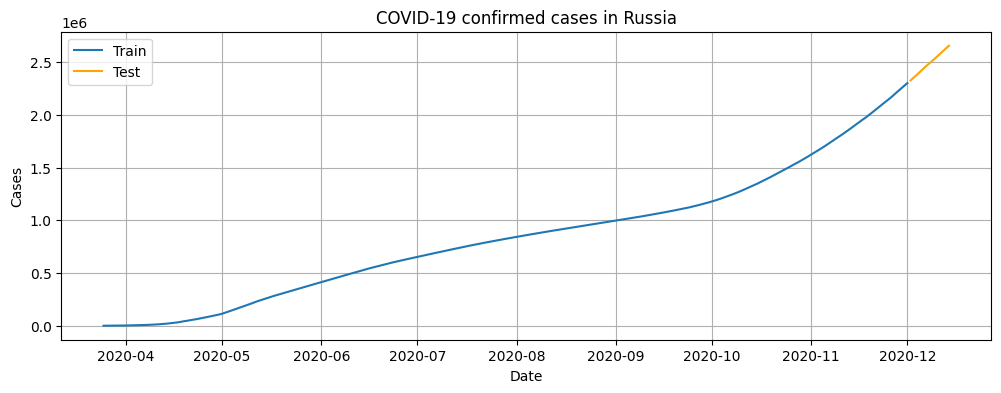

In [15]:
# Визуализация разделения данных на обучающую и тестовую выборки для России
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train[train.country == 'Russia']["date"], train[train.country == 'Russia']["confirmed"], label="Train")
ax.plot(test[test.country == 'Russia']["date"], test[test.country == 'Russia']["confirmed"], label="Test", color="orange")
ax.set(title=f"COVID-19 confirmed cases in Russia", ylabel="Cases", xlabel="Date")
ax.legend()
plt.grid()
plt.show()

In [16]:
# Установка столбца 'date' в качестве индекса датафрейма
df.set_index('date',  inplace =True)

# Переименование столбцов для соответствия именам, используемым в модели
df.rename(columns = {
    'country': 'location',
    'confirmed': 'total',
    'new_cases': 'positive'
}, inplace = True)
# Вывод первых 3 строк измененного датафрейма для проверки
df.head(3)

,location,total,deaths,recovered,reproduction_rate,positive,new_deaths,start_date,days_since_100
date,,,,,,,,,
2020-03-05,France,423.0,7.0,NaN,NaN,138,3,2020-03-05,0
2020-03-06,France,613.0,9.0,NaN,NaN,190,2,2020-03-05,1
2020-03-07,France,938.0,16.0,NaN,NaN,325,7,2020-03-05,2


# Построение генеративной модели

**Схема модели**


\[
\begin{aligned}
\log R(t) &= \log R(t-1) + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2) \\
R(t) &= \exp(\log R(t)) \\
y_0 &\sim \text{Exponential}(\lambda) \\
y_t &= \sum_{s=0}^{t-1} R(t) \, y_s \, g_{t-s} \\
d_t &= \sum_{s=0}^{t} y_s \, (f_\text{incub} * f_\text{delay})_{t-s} \\
\text{positive}_t &= \omega_t \, d_t \\
C_t &\sim \text{NegBinomial}(\mu = \text{positive}_t, \alpha)
\end{aligned}
\]

- \(R(t)\) — динамическое репродуктивное число  
- \(y_t\) — истинные новые инфекции  
- \(d_t\) — инфекции, скорректированные на задержку  
- \(\{positive}_t\) — скорректированные на сезонность выявленные случаи  
- \(C_t\) — наблюдаемые данные



* Логарифм (R(t)) моделируется как **случайное блуждание** — это позволяет ему плавно изменяться со временем.
* (R(t)) показывает, сколько новых инфекций в среднем вызывает один заражённый человек в момент времени (t).
* (y_0) — начальное количество инфицированных.
* Моделируется из **экспоненциального распределения**, что позволяет задать правостороннее распределение
* (y_t) — истинное (ненаблюдаемое) число новых инфекций в момент времени (t).
* Вычисляется как сумма по всем прошлым случаям (y_s), умноженным на:
* Новые инфекции зависят от предыдущих заражений и их распределённого во времени вклада.
* (d_t) — число инфекций, скорректированное на **время инкубации** и **задержку отчётности**.
* (f_\text{incub}) — распределение времени инкубационного периода
* (f_\text{delay}) — распределение задержки между симптомами и регистрацией случая.
* (C_t) — наблюдаемые данные (зарегистрированные случаи).
* Моделируются через **негативное биномиальное распределение**, что учитывает **переизбыток дисперсии** (overdispersion), свойственный реальным эпидемическим данным.


In [17]:
# Функция для получения вероятности задержки от заражения до сообщения о положительном тесте
def get_p_delay():
    # Параметры для гамма-распределения, основанные на исследованиях времени задержки
    alpha, beta = 2.305, 0.59
    # Диапазон дней для расчета вероятности задержки
    p_delay_range = np.arange(20)
    # Расчет значений функции плотности вероятности (PDF) для каждого дня в диапазоне
    return stats.gamma.pdf(p_delay_range, alpha, scale=1.0 / beta)


# Функция для получения вероятности времени инкубации
def get_incubation_time_interval():
    # Параметры для гамма-распределения, основанные на исследованиях времени инкубации
    alpha, beta = 1.352, 0.265
    # Диапазон дней для расчета вероятности времени инкубации
    incubation_time_range = np.arange(20)
    # Расчет значений функции плотности вероятности (PDF) для каждого дня в диапазоне
    return stats.gamma.pdf(incubation_time_range, alpha, scale=1.0 / beta)

In [18]:
# Функция для подготовки матрицы свертки для моделирования временных рядов инфекций
def get_convolution_ready_gt(len_observed):
    # Получение распределения времени генерации
    gt = get_generation_time_interval()
    # Создание пустой матрицы свертки
    convolution_ready_gt = np.zeros((len_observed - 1, len_observed))
    # Заполнение матрицы на основе распределения времени генерации
    for t in range(1, len_observed):
        begin = np.maximum(0, t - len(gt) + 1)
        slice_update = gt[1: t - begin + 1][::-1]
        convolution_ready_gt[t - 1, begin: begin + len(slice_update)] = slice_update
    # Преобразование матрицы в общий (shared) тензор PyTensor
    return pytensor.shared(convolution_ready_gt.astype(pytensor.config.floatX))

In [19]:
# Генеративная модель прогноза заболеваний с использованием PyMC
# region: название региона (страны)
# observed: датафрейм с наблюдаемыми данными (ежедневные случаи) для данного региона
def build_model(region, observed):
    # Получение распределения вероятности задержки от заражения до выявления
    p_delay = get_p_delay()
    # Получение распределения вероятности времени инкубации
    incubation_time = get_incubation_time_interval()
    # Определение булевой маски для дней с ненулевым количеством наблюдаемых положительных случаев
    nonzero_days = observed.total.gt(0)
    # Длина наблюдаемого временного ряда (количество дней)
    len_observed = len(observed)
    # Получение матрицы свертки для времени генерации
    convolution_ready_gt = get_convolution_ready_gt(len_observed)

    # Определение координат для модели PyMC
    coords = {
        "date": observed.index.values,
        "nonzero_date": observed.index.values[observed.total.gt(0)],
    }

    # Построение модели PyMC с использованием контекстного менеджера
    with pm.Model(coords=coords) as model:
        # Логарифм эффективного репродуктивного числа R(t). Моделируется как случайное блуждание по Гауссу.
        log_r_t = pm.GaussianRandomWalk("log_r_t", sigma=0.035, dims=["date"])
        # Преобразование логарифма R(t) обратно в R(t)
        r_t = pm.Deterministic("r_t", pm.math.exp(log_r_t), dims=["date"])

        # Начальное количество инфекций (seed). Моделируется как экспоненциальное распределение.
        seed = pm.Exponential("seed", 1 / 0.02)
        # Инициализация вектора инфекций (y0) с начальным значением seed в первый день
        y0 = tt.zeros(len_observed, dtype=pytensor.config.floatX)
        y0 = tt.set_subtensor(y0[0], seed)

        # Функция шага для сканирования (scan) - моделирования распространения инфекции день за днем
        def step(t_idx, prev_y, r_t_sym, conv_gt):
            # Получение соответствующей строки из матрицы свертки времени генерации для текущего дня
            row = conv_gt[t_idx - 1]
            # Расчет ожидаемого числа инфекций на текущий день
            y_t = tt.sum(r_t_sym * prev_y * row)
            # Обновление вектора инфекций
            updated = tt.set_subtensor(prev_y[t_idx], y_t)
            return updated, {}

        # Выполнение сканирования (scan) для итеративного расчета инфекций на каждый день
        outputs, _ = pytensor.scan(
            fn=step,
            sequences=[tt.arange(1, len_observed, dtype='int64')],
            outputs_info=[y0],
            non_sequences=[r_t, convolution_ready_gt],
            n_steps=len_observed - 1,
        )
        # Определение детерминированной переменной "infections" (истинные инфекции)
        infections = pm.Deterministic("infections", outputs[-1], dims=["date"])

        # Свертка времени инкубации и задержки
        delay = np.convolve(incubation_time, p_delay)
        # Длина распределения задержки
        D = len(delay)
        # Создание матрицы свертки для задержки
        conv_mat = np.zeros((len_observed, len_observed), dtype=pytensor.config.floatX)
        # Заполнение матрицы свертки задержки
        for t in range(len_observed):
            for j in range(0, t + 1):
                k = t - j
                if k < D:
                    conv_mat[t, j] = delay[k]
        # Преобразование матрицы в общий (shared) тензор PyTensor
        conv_shared = pytensor.shared(conv_mat)

        # Веса для ежедневной сезонности обнаружения случаев
        w = pm.Dirichlet('omega', a=np.ones(7))
        # Ожидаемое количество положительных тестов, скорректированное на задержку
        test_adjusted_positive = pm.Deterministic(
            "test_adjusted_positive",
            tt.dot(conv_shared, infections),
            dims=["date"]
        )
        # Повторение весов сезонности
        omegas = pm.Deterministic('omegas', tt.repeat(w, len_observed)[:len_observed], dims=['date'])

        # Включение наблюдаемого общего количества тестов как данных в модель
        tests = pm.Data("tests", observed.total.values, dims=["date"])
        # Определение детерминированной переменной "exposure" (экспозиция)
        pm.Deterministic(
            "exposure",
            pm.math.clip(tests, observed.total.max() * 0.1, 1e9),
            dims=["date"]
        )

        # Ожидаемое количество положительных тестов, скорректированное как на задержку, так и на сезонность тестирования
        positive = pm.Deterministic("positive", omegas * test_adjusted_positive, dims=["date"])
        # Включение наблюдаемого количества положительных случаев (только ненулевые значения) как данных в модель
        nonzero_observed_positive = pm.Data(
            "nonzero_observed_positive",
            observed.positive[nonzero_days.values].values,
            dims=["nonzero_date"]
        )
        # Моделирование наблюдаемых ненулевых положительных случаев с использованием отрицательного биномиального распределения.
        pm.NegativeBinomial(
            "nonzero_positive",
            mu=positive[nonzero_days.values],
            alpha=pm.Gamma("alpha", mu=6, sigma=1),
            observed=nonzero_observed_positive,
            dims=["nonzero_date"]
        )

    # Возврат построенной модели PyMC
    return model


# Функция для семплирования (получения выборок из апостериорного распределения) из построенной модели с использованием MCMC
# model: построенная модель PyMC
# kwargs: дополнительные аргументы для функции pm.sample
def sample_model(model, **kwargs):
    # Параметры по умолчанию для семплирования MCMC
    defaults = dict(cores=2, chains=2, tune=500, draws=100, target_accept=0.95, init="jitter+adapt_diag")
    # Обновление параметров по умолчанию переданными аргументами
    defaults.update(kwargs)
    # Запуск семплирования с использованием контекстного менеджера модели
    with model:
        # pm.sample: выполняет MCMC семплирование
        idata = pm.sample(return_inferencedata=True, **defaults)
    # Возврат результатов семплирования в формате InferenceData
    return idata

In [20]:
# Функция для предварительной обработки наблюдаемых данных перед передачей в модель
# region: название региона (страны)
# observed: исходный датафрейм с наблюдаемыми данными для данного региона
# buffer_days: количество буферных дней для добавления перед первым случаем
def preprocess_observed(region, observed, buffer_days=100):
    # Находим индекс первой строки, где количество положительных случаев не равно нулю
    first_index = observed.positive.ne(0).argmax()
    # Обрезаем датафрейм, оставляя данные начиная с первого ненулевого случая
    observed = observed.iloc[first_index:]
    # Создаем новый индекс дат, начиная за buffer_days дней до первого ненулевого случая
    new_index = pd.date_range(
        start=observed.index[0] - pd.Timedelta(days=buffer_days),
        end=observed.index[-1],
        freq="D",
    )
    # Переиндексируем датафрейм, добавляя буферные дни и заполняя отсутствующие значения нулями
    observed = observed.reindex(new_index, fill_value=0)
    # Возвращаем предобработанный датафрейм
    return observed

In [21]:
# Функция для получения интервала времени генерации (generation time)
# mean_si: среднее значение последовательного интервала (serial interval)
# std_si: стандартное отклонение последовательного интервала
def get_generation_time_interval():
    # Параметры для логнормального распределения
    mean_si = 4.7
    std_si = 2.9
    # Расчет параметров mu и sigma для логнормального распределения
    mu_si = np.log(mean_si ** 2 / np.sqrt(std_si ** 2 + mean_si ** 2))
    sigma_si = np.sqrt(np.log(std_si ** 2 / mean_si ** 2 + 1))
    # Создание объекта логнормального распределения
    dist = stats.lognorm(scale=np.exp(mu_si), s=sigma_si)

    # Диапазон дней для расчета вероятности времени генерации
    g_range = np.arange(0, 20)
    # Расчет кумулятивной функции распределения (CDF)
    gt = pd.Series(dist.cdf(g_range), index=g_range)
    # Расчет разницы между значениями CDF для получения вероятности
    gt = gt.diff().fillna(0)
    # Нормализация вероятностей
    gt /= gt.sum()
    # Возвращаем значения вероятностей как массив numpy
    return gt.values

In [22]:
# Функция для суммирования результатов инференса (семплирования) из объекта InferenceData
# idata: объект InferenceData с результатами семплирования
def summarize_inference_data(idata):
    # Извлечение апостериорного распределения
    posterior = idata.posterior

    # Внутренняя функция для расчета медианы по времени
    def _summary(varname):
        # Получение значений переменной из апостериорного распределения
        arr = posterior[varname].values
        # Сглаживание массива
        flat = arr.reshape(-1, arr.shape[-1])
        # Расчет медианы по оси 0
        median = np.median(flat, axis=0)
        # Возврат медианы как Series с индексом дат
        return pd.Series(median, index=idata.posterior[varname].coords["date"].values)

    # Создание датафрейма с медианными значениями для ключевых переменных модели
    result = pd.DataFrame({
        "infections": _summary("infections"),
        "test_adjusted_positive": _summary("test_adjusted_positive"),
        "median_rt": _summary("r_t"),
    })
    # Возврат результирующего датафрейма
    return result

In [23]:
# Функция для визуализации и сохранения графика ожидаемых инфекций и положительных тестов
# region: название региона (страны)
# observed: предобработанный датафрейм с наблюдаемыми данными
# result_df: датафрейм с результатами инференса
# save_dir: директория для сохранения графиков
def plot_infections_and_tests(region, observed, result_df, save_dir="results"):
    """Визуализация и сохранение графика ожидаемых инфекций и положительных тестов"""
    # Создание директории для сохранения, если она не существует
    os.makedirs(save_dir, exist_ok=True)

    # Создание графика с использованием matplotlib
    fig, ax = plt.subplots(figsize=(12, 8))
    # Построение линии ожидаемых инфекций
    result_df['infections'].plot(c="C2", label="Expected infections", ax=ax)
    # Построение линии ожидаемых положительных тестов
    result_df['test_adjusted_positive'].plot(c="C0", label="Expected positive tests", ax=ax)
    # Построение линии наблюдаемых положительных тестов
    observed.positive.plot(c="C7", alpha=0.7, label="Reported positives", ax=ax)
    ax.legend()
    # Установка заголовка и подписи оси Y
    ax.set(title=f"{region}: infections vs positives", ylabel="Cases")
    sns.despine()

    # Сохранение графика в файл
    filename = os.path.join(save_dir, f"{region}_infections_vs_tests.png")
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    print(f"✅ Сохранен график: {filename}")

    plt.show()


# Функция для построения графика постериорного предсказания положительных случаев
# region: название региона (страны)
# data_region: исходный датафрейм с данными для региона
# model: построенная модель PyMC
# idata: объект InferenceData с результатами семплирования
# save_dir: директория для сохранения графиков
def plot_posterior_predictive(region, data_region, model, idata, save_dir="results"):
    """График постериорного предсказания с медианой и 90% доверительным интервалом"""
    # Создание директории для сохранения, если она не существует
    os.makedirs(save_dir, exist_ok=True)

    # Генерация постериорных предсказаний для переменной "nonzero_positive"
    with model:
        ppc = pm.sample_posterior_predictive(
            idata, var_names=["nonzero_positive"], return_inferencedata=False
        )

    # Извлечение предсказанных значений положительных случаев
    y_pred = np.squeeze(ppc["nonzero_positive"])
    # Приведение к двумерному массиву
    if y_pred.ndim == 3:
        y_pred = y_pred.reshape(-1, y_pred.shape[-1])

    # Расчет медианы и 90% доверительного интервала (HPD) для предсказаний
    median = np.median(y_pred, axis=0)
    hpd_lower = np.percentile(y_pred, 5, axis=0)
    hpd_upper = np.percentile(y_pred, 95, axis=0)

    # Создание графика с использованием matplotlib
    fig, ax = plt.subplots(figsize=(12, 8))
    # Построение нескольких случайных выборок из предсказаний
    for sample in y_pred[:200]:
        ax.plot(sample, color="0.5", alpha=0.05)

    # Заполнение области между нижней и верхней границами 90% доверительного интервала
    ax.fill_between(
        np.arange(len(median)),
        hpd_lower,
        hpd_upper,
        color="C0",
        alpha=0.3,
        label="90% credible interval"
    )

    # Построение линии медианы предсказаний
    ax.plot(median, color="C0", lw=2, label="Posterior median")
    # Построение линии наблюдаемых положительных случаев
    ax.plot(data_region.positive[data_region.positive.gt(0)].values, color="r", lw=2, label="Observed")
    # Установка предела оси Y
    ax.set_ylim(0, max(data_region.positive.values) * 1.2)
    ax.set_title(f"Posterior nonzero positive cases for {region}")
    ax.legend()

    # Сохранение графика в файл
    filename = os.path.join(save_dir, f"{region}_posterior_predictive.png")
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    print(f"Сохранен график: {filename}")

    plt.show()

# Результат работы модели по каждой стране

Сохранен график: results/Russia_posterior_predictive.png


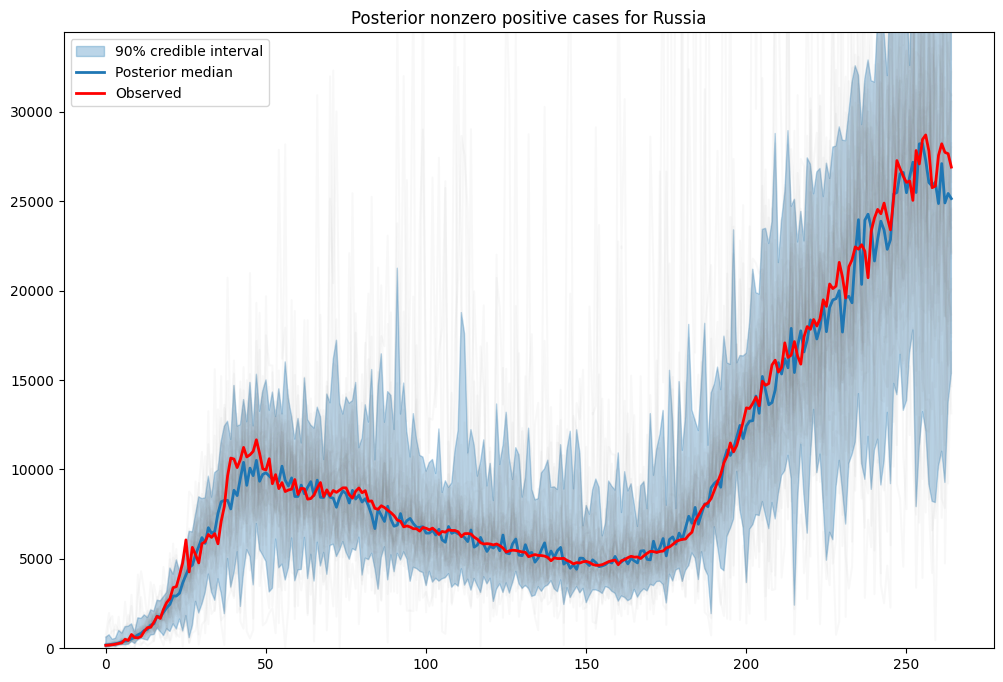

In [24]:
# Создание директории для сохранения результатов, если она не существует
os.makedirs("results", exist_ok=True)
# Получение списка уникальных стран из датафрейма
countries = df["location"].unique()

# Итерация по каждой стране для построения и семплирования модели
for region in tqdm(countries):
    print("=" * 80)
    print(f"Обработка {region}")
    # Выбор данных только для текущей страны
    data_country = df[df["location"] == region]

    try:
        # Предварительная обработка наблюдаемых данных
        obs = preprocess_observed(region, data_country)
        #  Построение стохастической генеративной модели
        model = build_model(region, obs)
        #  Семплирование из построенной модели
        idata = sample_model(
            model,  # структура вероятностной модели
            cores=4,  # Количество процессорных ядер (CPU),
            chains=4,  # Количество цепей МСМС
            draws=10,  # Количество сэмплов, которые будут сохранены после tune
            tune=30  #  количество итераций разогрева""
        )

        # Суммирование результатов инференса
        result = summarize_inference_data(idata)

        #  Сохранение визуализаций результатов
        plot_infections_and_tests(region, obs, result)
        plot_posterior_predictive(region, data_country, model, idata)

    except Exception as e:
        print(f"Ошибка при обработке {region}: {e}")
        continue

In [25]:
# сохранение в зип
# Папка, которую архивируем
folder_path = "results"

# Имя итогового архива
zip_filename = "results_backup"

# Проверяем, что папка существует
if os.path.exists(folder_path):
    # Создаём ZIP-архив
    shutil.make_archive(zip_filename, 'zip', folder_path)
    print(f"Папка '{folder_path}' успешно сохранена как '{zip_filename}.zip'")
else:
    print(f"Папка '{folder_path}' не найдена.")


Папка 'results' успешно сохранена как 'results_backup.zip'
